In [51]:
# get environment variables
import os
import sys
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

import xarray as xr
import numpy as np
sys.path.append(os.environ.get('srcdir'))
from features.pySSA.mySSA import mySSA
import pandas as pd
from features.log_progress import log_progress
import matplotlib.pyplot as plt
from scipy.signal import detrend

In [198]:
# load tides and no tides hourly melting over two month
file_path = os.path.join(os.environ.get('rawdir'),'waom10_v2.0_star','ocean_his_hourly.nc')
tides = xr.open_dataset(file_path).isel(eta_rho=slice(270,390),xi_rho=slice(150,250),ocean_time=slice(0,720))

file_path = os.path.join(os.environ.get('rawdir'),'waom10_v2.0_star_noTides','ocean_his_hourly.nc')
noTides = xr.open_dataset(file_path).isel(eta_rho=slice(270,390),xi_rho=slice(150,250),ocean_time=slice(0,720))

# load grid
grid_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_v2.0_frc','waom10_small_grd.nc')
grd = xr.open_dataset(grid_path).isel(eta_rho=slice(270,390),xi_rho=slice(150,250))

In [199]:
tides.ocean_time[0] == noTides.ocean_time[0]

<xarray.DataArray 'ocean_time' ()>
array(True, dtype=bool)
Coordinates:
    ocean_time  datetime64[ns] 2014-12-30

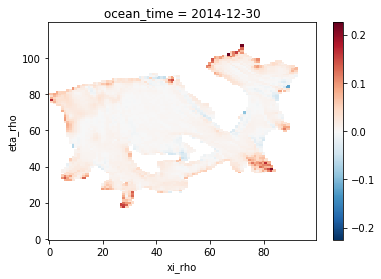

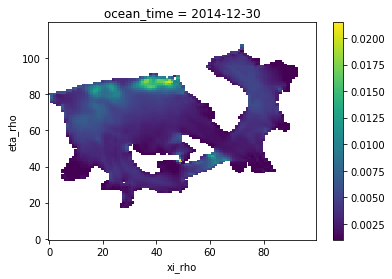

In [191]:
%matplotlib inline
plt.close()
tides.Tstar[0].where((grd.zice<0) & (grd.mask_rho==1)).plot()
plt.show()
tides.Ustar[0].where((grd.zice<0) & (grd.mask_rho==1)).plot()
plt.show()

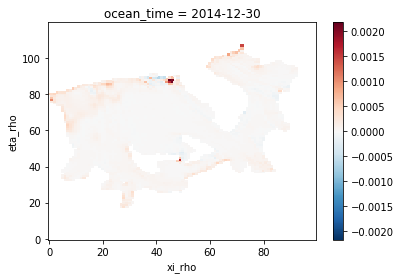

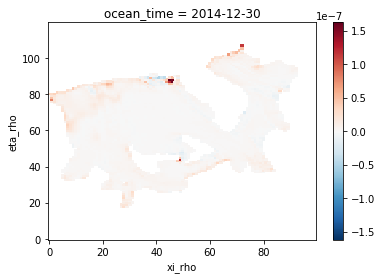

In [20]:
plt.close()
(tides.Tstar[0]*tides.Ustar[0]).where((grd.zice<0) & (grd.mask_rho==1)).plot()
plt.show()
tides.m[0].where((grd.zice<0) & (grd.mask_rho==1)).plot()
plt.show()

In [200]:
def get_lp_hp(ts,K):
    
    if np.var(ts.values) == 0:
        
        zeros = np.zeros_like(ts.values)
        
        hp_cell = zeros
        lp_cell = zeros 
        
    else:
    
        #ts[:].values = detrend(ts.values,-1,'linear')
        ssa = mySSA(ts.to_dataframe()[ts.name])

        ssa.embed(embedding_dimension=K)
        ssa.decompose()

        slow_rho_idx = np.array([np.argmax(np.abs(ssa.U.sum(0))/(np.abs(ssa.U).sum(0)))])
        fast_rho_idx = np.delete(range(K),slow_rho_idx)

        lp = ssa.view_reconstruction(*[ssa.Xs[i] for i in slow_rho_idx], return_df=True,plot=False)
        hp = ssa.view_reconstruction(*[ssa.Xs[i] for i in fast_rho_idx], return_df=True,plot=False)
        
        lp_cell = lp.values.squeeze()
        hp_cell = hp.values.squeeze()
        
    return lp_cell, hp_cell
    

def get_lp_hp_map(ts_map,grd,K):
    
    lp_map = ts_map.load().drop('ocean_time').copy()
    hp_map = lp_map.copy()            
    
    for j in log_progress(ts_map.eta_rho.values,name='eta'):
        for i in ts_map.xi_rho.values:
            
            if (grd.mask_rho[j,i]==1) and (grd.zice[j,i]<0.0):
                lp,hp = get_lp_hp(ts_map[:,j,i],K)
            
                lp_map[:lp.size,j,i] = lp
                hp_map[:hp.size,j,i] = hp
                
            else:
                
                lp_map[:,j,i] = 0
                hp_map[:,j,i] = 0
            
    lp_map = lp_map[:lp.size].copy()
    hp_map = hp_map[:hp.size].copy()
        
    return lp_map, hp_map

In [196]:
cell = tides.isel(eta_rho=80,xi_rho=20,ocean_time=slice(0,720))
Ustar_lp,Ustar_hp = get_lp_hp(cell.Ustar,24)
Tstar_lp,Tstar_hp = get_lp_hp(cell.Tstar,24)

0.000280834


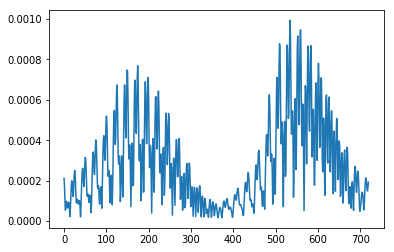

0.000280477498791


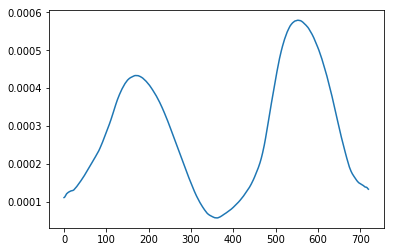

-5.5660160413e-08


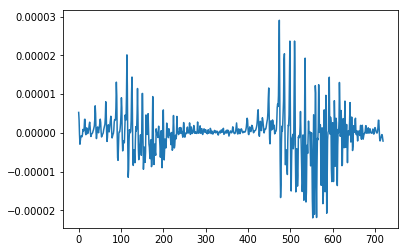

In [197]:
plt.close()
plt.plot(cell.Tstar.values*cell.Ustar.values)
print(np.mean(cell.Tstar.values*cell.Ustar.values))
plt.show()
plt.plot(Tstar_lp*Ustar_lp)
print(np.mean(Tstar_lp*Ustar_lp))
plt.show()
plt.plot(Tstar_hp*Ustar_hp)
print(np.mean(Tstar_hp*Ustar_hp))
plt.show()

In [201]:
tides['u_lp'],tides['u_hp'] = get_lp_hp_map(tides.Ustar,grd,24)
tides['T_lp'],tides['T_hp'] = get_lp_hp_map(tides.Tstar,grd,24)

VBox(children=(HTML(value=''), IntProgress(value=0, max=120)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=120)))

In [202]:
noTides['u_lp'],noTides['u_hp'] = get_lp_hp_map(noTides.Ustar,grd,24)
noTides['T_lp'],noTides['T_hp'] = get_lp_hp_map(noTides.Tstar,grd,24)

VBox(children=(HTML(value=''), IntProgress(value=0, max=120)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=120)))

In [208]:
for ds in [tides,noTides]:
    ds['mstar']=(ds.Ustar*ds.Tstar).where((grd.zice<0) & (grd.mask_rho==1)).mean('ocean_time')
    ds['mstar_slow'] = (ds.u_lp*ds.T_lp).where((grd.zice<0) & (grd.mask_rho==1)).mean('ocean_time')
    ds['mstar_fast'] =(ds.u_hp*ds.T_hp).where((grd.zice<0) & (grd.mask_rho==1)).mean('ocean_time')
    
    ds['mstar_slow_rel'] = (ds.mstar_slow)/ds.mstar*100
    ds['mstar_fast_rel'] = (ds.mstar_fast)/ds.mstar*100

In [245]:
#plot mean of raw, low pass and high pass filtered Ustar*Tstar
vmax= (tides.mstar.mean()+tides.mstar.std()).values

def plot_mean(tides,noTides):
    plt.close()
    fig,axes = plt.subplots(ncols=3,nrows=3,figsize=(15,10))

    noTides.mstar.plot(ax=axes[0,0],vmin=0,vmax=vmax)
    axes[0,0].text(0.5,-0.1, 'mean = %.3g'%noTides.mstar.mean().values, size=12, ha="center", transform=axes[0,0].transAxes)
    
    tides.mstar.plot(ax=axes[0,1],vmin=0,vmax=vmax)
    axes[0,1].text(0.5,-0.1, 'mean = %.3g'%tides.mstar.mean().values, size=12, ha="center", transform=axes[0,1].transAxes)
    
    ((tides.mstar-noTides.mstar)).plot(ax=axes[0,2],vmin=0,vmax=vmax)
    axes[0,2].text(0.5,-0.1, 'mean = %.3g'%(tides.mstar-noTides.mstar).mean().values, size=12, ha="center", transform=axes[0,2].transAxes)

    noTides.mstar_slow_rel.plot(ax=axes[1,0],vmin=-100,vmax=100)
    axes[1,0].text(0.5,-0.1, 'mean = %.3g'%noTides.mstar_slow_rel.mean().values, size=12, ha="center", transform=axes[1,0].transAxes)
    
    tides.mstar_slow_rel.plot(ax=axes[1,1],vmin=-100,vmax=100)
    axes[1,1].text(0.5,-0.1, 'mean = %.3g'%tides.mstar_slow_rel.mean().values, size=12, ha="center", transform=axes[1,1].transAxes)
    
    ((tides.mstar_slow_rel - noTides.mstar_slow_rel)).plot(ax=axes[1,2],vmin=-100,vmax=100)
    axes[1,2].text(0.5,-0.1, 'mean = %.3g'%(tides.mstar_slow_rel - noTides.mstar_slow_rel).mean().values, size=12, ha="center", transform=axes[1,2].transAxes)

    noTides.mstar_fast_rel.plot(ax=axes[2,0],vmin=-2,vmax=2)
    axes[2,0].text(0.5,-0.1, 'mean = %.3g'%noTides.mstar_fast_rel.mean().values, size=12, ha="center", transform=axes[2,0].transAxes)

    tides.mstar_fast_rel.plot(ax=axes[2,1],vmin=-2,vmax=2)    
    axes[2,1].text(0.5,-0.1, 'mean = %.3g'%tides.mstar_fast_rel.mean().values, size=12, ha="center", transform=axes[2,1].transAxes)

    ((tides.mstar_fast_rel - noTides.mstar_fast_rel)).plot(axes=axes[2,2],vmin=-2,vmax=2)
    axes[2,2].text(0.5,-0.1, 'mean = %.3g'%(tides.mstar_fast_rel - noTides.mstar_fast_rel).mean().values, size=12, ha="center", transform=axes[2,2].transAxes)

    for ax in axes.flatten():
        ax.set_aspect('equal')
        ax.axis('off')

    cols = ['Without tides','With tides','Difference']
    rows = ['Ustar*Tstar','% Ustar*Tstar \n > 24h band','% Ustar*Tstar \n < 24h band']

    pad = 5 # in points

    for ax, col in zip(axes[0], cols):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')

    for ax, row in zip(axes[:,0], rows):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')

    fig.tight_layout()

    fig.subplots_adjust(left=0.15, top=0.95)

    plt.show()


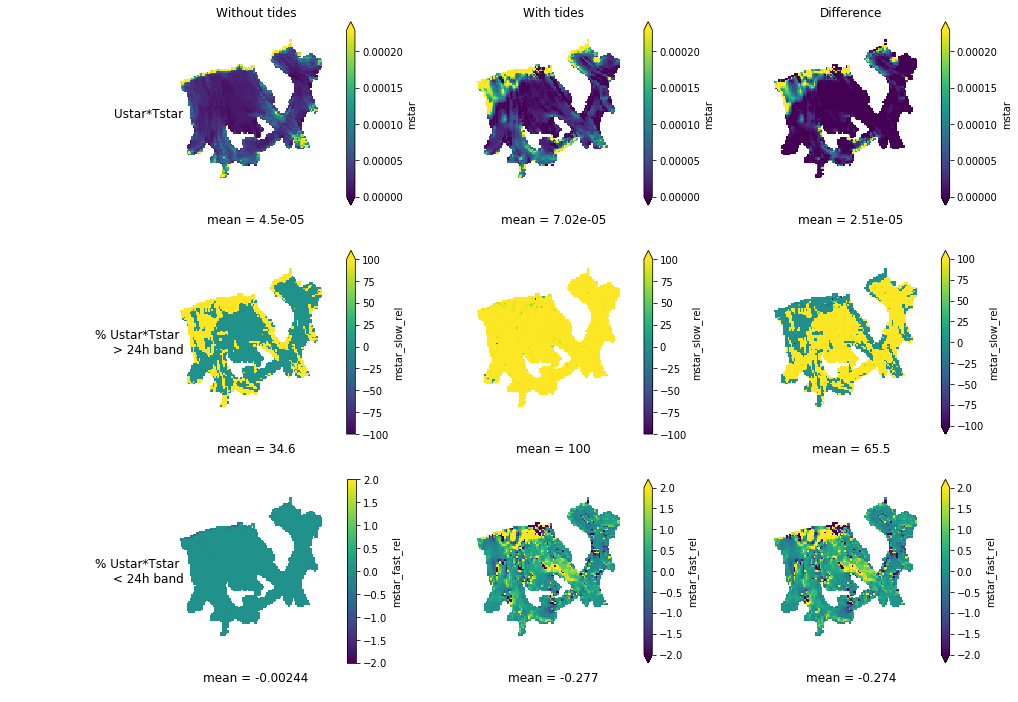

In [246]:
%matplotlib inline
plot_mean(tides,noTides)